## Predicting the outcome of a Kickstarter project
### by Daniel Schwarz


In this project I explores a dataset of >13000 projects from Kickstarter. The dataset was obtained by querying directly the (undocumented) kickstarter API. The dataset contains information the project goal, the outcome (successfull, failed, how much was in the end pledged for, backers count), project location, the category and also time lines telling the amount of the goal pledged as a function of time to the deadline. I will use all this information to predict the outcome (i.e., whether a project will be successful or not) of unknown projects.


### 0. Loading the dataset and some transformations

In [187]:
# necessary imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymongo

from datetime import datetime
from datetime import datetime as dt
from datetime import timedelta
import dateutil

from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import prettytable
sns.set_palette(c_cmap.mpl_colors, desat=.8, n_colors=5)
sns.set_style(sns.axes_style('white'))

from pylab import rcParams

rcParams['axes.titlesize'] = 16
rcParams['ytick.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['axes.labelsize'] = 14
rcParams['legend.fontsize'] = 14

from matplotlib.ticker import FixedFormatter

scorer = make_scorer(f1_score)

%matplotlib inline

      
def get_timeline(proj):
    # extracts a timeline from a 'status' element
    deadline = proj['deadline']
    stati = []
    for status in proj['status']:
        pledged = float(status['pledged'])/float(status['goal'])
        time_left = deadline - status['time']
        stati.append(np.array([pledged, time_left.total_seconds()]))
    return stati



In [130]:
## Load the dataste from a mongoDB database / from pickle

connection = pymongo.MongoClient(host='192.168.2.21')
db = connection['kickstarter']
collection = db['projects']

projects = [p for p in collection.find({'state' : {'$in' : ['successful', 'failed']}})]

df = pd.DataFrame(projects)

#df.to_pickle('df.pickle')
#df = pd.read_pickle('df.pickle')

In [132]:
# each 'status' field contains a list of time / amount pledged entries
# we extract a timeline array 
timelines = []
for i in xrange(len(df)):
    timelines.append(get_timeline(df.ix[i]))
    
# get lists with the (relative) amount pledged, the time left, the outcome (successful, failed)
# and the slope of the amount pledged.
pledged = []
time = []
state = []
pledged_slopes = []
project_ids = []

for i in xrange(len(timelines)):
    [pledged.append(t[0]) for t in timelines[i]]
    [time.append(t[1]) for t in timelines[i]]
    [state.append(df.ix[i].state) for t in timelines[i]]
    slopes = [(1.*t1[0]-1.*t2[0])/(t2[1]-t1[1]) for t1,t2 in zip(timelines[i][:-1], 
                                                                 timelines[i][1:])]
    slopes.append(np.nan)
    [pledged_slopes.append(s) for s in slopes]
    [project_ids.append(str(df.ix[i]._id)) for t in timelines[i]]

# Combine all lists to a new dataframe
df_time = pd.DataFrame([project_ids, pledged, time, pledged_slopes, state])
df_time = df_time.T
df_time.columns =['ids','pledged','timeleft','pledged_slope','state']

# get rid of all entries of finished, successful projects
df_time.drop(df_time[df_time.pledged > 1.].index, inplace=True)

# get rid of all entries with no slope (i.e. the first entry of a timeline)
df_time.drop(df_time[df_time.pledged_slope.isnull()].index, inplace=True)
df_time.reset_index(inplace=True, drop=True)

# 1 is successful, 0 is failed
df_time.state = df_time.state.apply(lambda x: 1 if x=='successful' else 0)

#df_time.to_pickle('timeline_df.pickle')

KeyboardInterrupt: 

Now we combine the new timeline dataframe back with the dataframe containing the remaining
information (category, location etc).


In [134]:
df._id = df._id.apply(lambda x: str(x))
merged = df_time.merge(df, how='inner', left_on='ids', right_on='_id')

# Get the timeframe feature (total time of the campaign from launch
# to deadline)
merged['timeframe'] = merged.deadline - merged.launched_at
merged['timeframe'] = merged.timeframe.apply(lambda x: int(x))

# We should limit to the most common countries, 
# otherwise there are too many features.
merged['location_country'] = merged.location.apply(lambda x: x['country'])
merged = merged[merged.location_country.isin(
        merged.location_country.value_counts().index[:15])]

merged['usd_goal'] = 1.*merged.goal * merged.static_usd_rate
merged['category_parent'] = merged.category.apply(lambda x: x['slug'].split('/')[0])
# fix ampersand encoding issue
merged.loc[merged.category_parent=='film &amp; video', 
           'category_parent'] = 'film & video' 


# the amount missing per days left
merged['goal_day'] = (1-merged.pledged_x)/(merged.timeleft/(24.*3600))

# select continuous and categorical features
features_cont = ['usd_goal','timeframe', 'pledged_x', 
                 'pledged_slope', 'timeleft', 'goal_day']
features_cat = ['location_country', 'category_parent']

# build a new dataframe for training / testing with the selected features
cont_df = merged[features_cont+['ids']]

# replace catogrical features with dummies
for cat in features_cat:
    df = pd.get_dummies(merged[cat])
    cont_df = pd.concat([cont_df, df], axis=1, copy=True)

cont_df['state'] = merged.state_x

my_df = cont_df.copy()
my_df.reset_index(inplace=True, drop=True)

In [135]:
# finally we split the data into a training and test set
# using the unique project ids
# Holding back 30% for cv

ids_ = my_df.ids.unique()
train_ids, test_ids = train_test_split(ids_, train_size = 0.7)

train_df = my_df[my_df.ids.isin(train_ids)]
test_df = my_df[my_df.ids.isin(test_ids)]

feats = [feature for feature in my_df.columns if feature not in ['ids', 'state']]

### 1. Some data exploring 

Let's look at the amount pledged versus days left before the deadline for projects for different outcome (successful, failed). Not too surprising to find a clear separation between projects of both outcomes...

**Successful** projects are **red**, **failed** projects are **blue**.

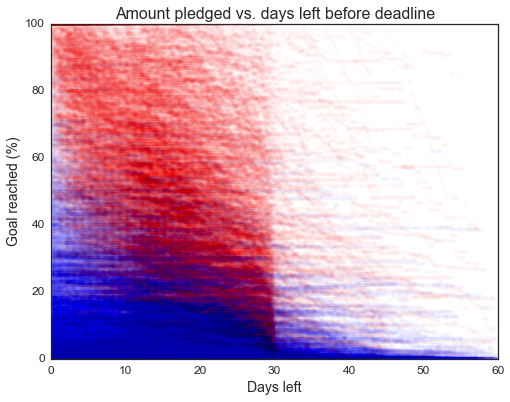

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(train_df.timeleft/(24.*3600.),
            100*train_df.pledged_x, 
            c = list(train_df.state), 
            alpha=0.01,
           cmap='bwr')
plt.ylim(0, 100)
plt.xlim(0, 60)
plt.xlabel('Days left')
plt.ylabel('Goal reached (%)')
plt.title('Amount pledged vs. days left before deadline')

And the same for the relative change in the amount pledged. 
Again **successful** projects are **red**, **failed** projects are **blue**.

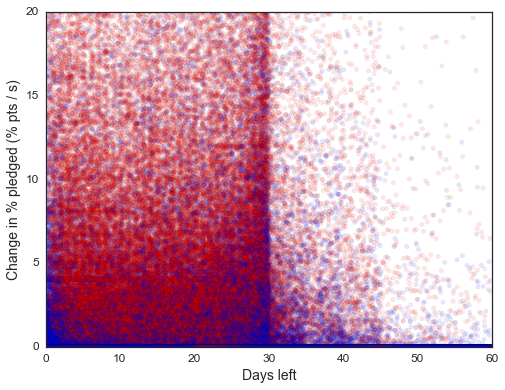

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(train_df.timeleft/(24.*3600.),
            100*train_df.pledged_slope*3600*24., 
            c=list(train_df.state), 
            alpha=.1, 
            cmap='bwr')
plt.ylim(0,20)
plt.xlim(0, 60)
plt.xlabel('Days left')
plt.ylabel('Change in % pledged (% pts / s)')


### 2. Fitting the classifier

I use the RandomForestClassifier from the sklearn module to predict the possible outcome of a project. The main parameters for this classifier is the number of estimators and the number of features used per estimator. Using GridSearchCV and 4 fold cross validation we can find the optimal values for these parameters. 


This will take a while to finish...

In [163]:
clf = RandomForestClassifier()

params = dict(n_estimators=[10,100,200],
             max_features = [5, 10, 20, 30])

grid_search = GridSearchCV(clf, params, scoring=scorer, n_jobs=4, cv=4)
grid_search.fit(train_df[feats], train_df.state)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=4,
       param_grid={'max_features': [5, 10, 20, 30], 'n_estimators': [10, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(f1_score), verbose=0)

### 3. Evaluation

First some key metrics: 

In [ ]:
clf = grid_search.best_estimator_

In [189]:
predicted = clf.predict(test_df[feats])

print 'F1 score: ', f1_score(predicted, test_df.state)
print 'Precision score: ', precision_score(predicted, test_df.state)
print 'Recall score: ', recall_score(predicted, test_df.state)
print 'Accuracy score: ', accuracy_score(predicted, test_df.state)

F1 score:  0.821196067259
Precision score:  0.840971354318
Recall score:  0.802329437776
Accuracy score:  0.914977306529
[[374560  25033]
 [ 19214 101607]]


How are these scores changing depending on the time left from the deadline? 

In [174]:
# creating a new feature: full days left
test_df.loc[test_df.index, 'days_left'] = test_df.timeleft.apply(lambda x: np.round(x/(24*3600.)))

# groupby this new feature
by_days = test_df.groupby('days_left')

# calculate the score for each group
scores = []
for group in by_days:
    scores.append(dict(f1 = f1_score(clf.predict(group[1][feats]), 
                                     group[1]['state']),
                       precision = precision_score(clf.predict(group[1][feats]), 
                                                   group[1]['state']),
                       recall = recall_score(clf.predict(group[1][feats]), 
                                             group[1]['state']),
                        accuracy = accuracy_score(clf.predict(group[1][feats]), 
                                             group[1]['state'])))


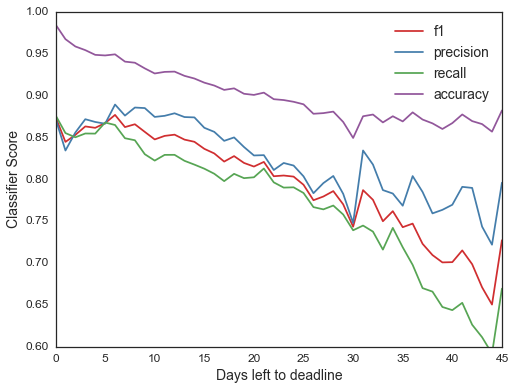

In [175]:
plt.figure(figsize=(8,6))

for score in ['f1','precision','recall', 'accuracy']:
    plt.plot(by_days.groups.keys(), [s[score] for s in scores], 
             label=score)
plt.xlim(0, 45)
plt.ylim(0.6, 1.0)

plt.xlabel('Days left to deadline')
plt.ylabel('Classifier Score')
plt.legend(loc='best')


So the closer the projects to the deadline, the more accurate our prediction. At 45 days away from the deadline the F1-score is around 0.7. However, the closer the deadline the better the prediction. 

#### The most important features are and their relative importance in the classifier are:

In [156]:
importances  =clf.feature_importances_

sorting = np.argsort(importances)
np.array(feats)[sorting][::-1]

table = prettytable.PrettyTable(["Feature name", "Model importance"])

for feat, importance in zip(np.array(feats)[sorting][:-8:-1], 
                            np.sort(importances)[:-8:-1]):
    table.add_row([feat, importance])

print table

+---------------+------------------+
|  Feature name | Model importance |
+---------------+------------------+
|   pledged_x   |  0.520842805591  |
|    goal_day   |  0.156220524196  |
|    usd_goal   | 0.0917166212077  |
|   timeframe   | 0.0759205299063  |
|    timeleft   | 0.0489258781718  |
|    theater    | 0.0102741897965  |
| pledged_slope | 0.00865948429435 |
+---------------+------------------+


The most important feature is the relative amount already pledged, followed by the amount of the goal still missing per day left and the goal. 

### 4. Conclusion

With an optimized classifier, we could predict the outcome of projects with an accuracy of more than 90%. The closer the deadline, the more accurate the predicted outcome. However, it is slighlty worrying, that the precision and recall scores never reach very high values right before the deadline. This is probably due to missing data: most successful projects finish well before the deadline, for the last days we have mostly failed projects left.  
